# Hoja de Trabajo 7 - Modelos de Regresión Logística
### Universidad del Valle de Guatemala
#### Minería de Datos

**Diego Garcia Valle** - 22404

**Pablo Cesar Lopez Medina** - 22535

GitHub: https://github.com/DiegoGarV/HDT7-DM 

In [42]:
# %pip install -r requirements.txt

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold


In [44]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

train_df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Punto 1 - Variables Dicotómicas

In [45]:
bins = [0, 130000, 200000, float('inf')]
labels = ['Barata', 'Media', 'Cara']
train_df['PrecioCategoria'] = pd.cut(train_df['SalePrice'], bins=bins, labels=labels)


In [46]:
# Crear variable categórica de precio
bins = [0, 130000, 200000, float('inf')]
labels = ['Barata', 'Media', 'Cara']
train_df['PrecioCategoria'] = pd.cut(train_df['SalePrice'], bins=bins, labels=labels)

# Crear variables dicotómicas
train_df['Es_Barata'] = (train_df['PrecioCategoria'] == 'Barata').astype(int)
train_df['Es_Media'] = (train_df['PrecioCategoria'] == 'Media').astype(int)
train_df['Es_Cara'] = (train_df['PrecioCategoria'] == 'Cara').astype(int)

# Verificar resultado
train_df[['SalePrice', 'PrecioCategoria', 'Es_Barata', 'Es_Media', 'Es_Cara']].head(10)


,SalePrice,PrecioCategoria,Es_Barata,Es_Media,Es_Cara
0,208500,Cara,0,0,1
1,181500,Media,0,1,0
2,223500,Cara,0,0,1
3,140000,Media,0,1,0
4,250000,Cara,0,0,1
5,143000,Media,0,1,0
6,307000,Cara,0,0,1
7,200000,Media,0,1,0
8,129900,Barata,1,0,0
9,118000,Barata,1,0,0


## Punto 2 – División del conjunto de datos

In [47]:
# Eliminar columnas no útiles o objetivo
excluded_columns = [
    'Id', 'SalePrice', 'PrecioCategoria', 'Es_Barata', 'Es_Media', 'Es_Cara'
]

# Seleccionar solo variables numéricas como features
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
features = [col for col in numeric_cols if col not in excluded_columns]

# Variables finales para modelado
X = train_df[features]
y = train_df['Es_Cara']


In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Train: (1095, 36), Test: (365, 36)


## Punto 3 – Modelo de regresión logística

In [49]:

# Pipeline: imputación + estandarización + modelo
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

# Validación cruzada con el pipeline completo
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

print("Accuracy en cada fold de validación cruzada:", cv_scores)
print("Accuracy promedio:", cv_scores.mean())


Accuracy en cada fold de validación cruzada: [0.92237443 0.9086758  0.92694064 0.89954338 0.92237443]
Accuracy promedio: 0.9159817351598173


### Validación cruzada con pipeline

Hasta este punto, nos dimos cuenta que el modelo de regresión logística no podía entrenarse directamente con los datos porque había valores NaN y también nos dio una advertencia de que no estaba convergiendo (es decir, no llegaba a una solución óptima dentro de las iteraciones permitidas).

Por eso, decidimos hacer un pipeline que básicamente hace tres cosas:
1. **Imputa** (rellena) los valores faltantes con la media de cada columna.
2. **Estandariza** los datos para que todas las variables estén en la misma escala. Esto ayuda a que el modelo entienda mejor los datos y converja más rápido.
3. **Entrena** un modelo de regresión logística con esas transformaciones aplicadas.

Después, usamos validación cruzada con 5 folds para ver qué tan bien se comporta el modelo en diferentes particiones de los datos.

Al interpretar los resultados podemos ver que el modelo logra predecir correctamente si una casa es cara o no con una precisión de aproximadamente **91.6%**, lo cual está bastante bien. Además, los resultados entre folds no varían demasiado, así que el modelo parece estable y no depende de una partición específica.


In [50]:
# Entrenar el pipeline completo sobre TODO el conjunto de entrenamiento
pipeline.fit(X_train, y_train)

# Extraer el modelo entrenado desde el pipeline
modelo_entrenado = pipeline.named_steps['logreg']

# Obtener los coeficientes
coeficientes = pd.DataFrame({
    "Variable": X_train.columns,
    "Coeficiente": modelo_entrenado.coef_[0]
}).sort_values(by="Coeficiente", ascending=False)

# Mostrar los 10 más influyentes
coeficientes.head(10)


,Variable,Coeficiente
3,OverallQual,1.614721
5,YearBuilt,1.085585
15,GrLivArea,0.895538
13,2ndFlrSF,0.834349
6,YearRemodAdd,0.624175
11,TotalBsmtSF,0.514237
2,LotArea,0.441470
25,GarageCars,0.404756
8,BsmtFinSF1,0.395582
4,OverallCond,0.394632


### Análisis de los coeficientes del modelo

Después de entrenar el modelo, revisamos los coeficientes para entender cuáles variables tienen más impacto en predecir si una casa es cara o no.

Los coeficientes más altos indican que al aumentar esa variable, también aumenta la probabilidad de que la casa sea cara.

#### Top 3 variables más influyentes:
1. **OverallQual** – Calidad general de la construcción: tiene el coeficiente más alto, lo cual tiene sentido porque mientras mejor es la calidad, más cara tiende a ser la casa.
2. **YearBuilt** – Año de construcción: las casas más nuevas suelen valer más.
3. **GrLivArea** – Área habitable sobre el suelo: más espacio = más valor.

Otras variables que también influyen bastante son 2ndFlrSF (segunda planta), GarageCars (espacio para autos) y TotalBsmtSF (sótano total), que también reflejan mayor comodidad o tamaño de la casa.

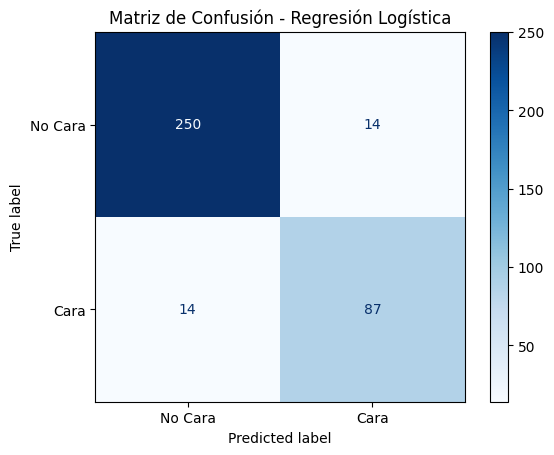

              precision    recall  f1-score   support

     No Cara       0.95      0.95      0.95       264
        Cara       0.86      0.86      0.86       101

    accuracy                           0.92       365
   macro avg       0.90      0.90      0.90       365
weighted avg       0.92      0.92      0.92       365



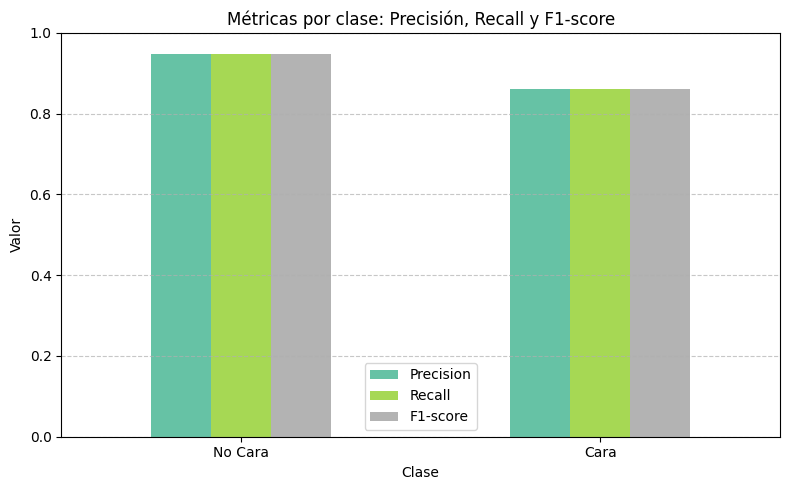

In [51]:

# Hacer predicciones con el conjunto de prueba
y_pred = pipeline.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Cara", "Cara"])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión - Regresión Logística")
plt.show()

# Reporte de clasificación
print(classification_report(y_test, y_pred, target_names=["No Cara", "Cara"]))


# Calcular métricas por clase manualmente
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

labels = ["No Cara", "Cara"]

# Crear un DataFrame para graficar
metricas_df = pd.DataFrame({
    "Clase": labels,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1
})

metricas_df.set_index("Clase").plot(kind="bar", figsize=(8, 5), ylim=(0, 1), colormap="Set2")
plt.title("Métricas por clase: Precisión, Recall y F1-score")
plt.ylabel("Valor")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



### Análisis de Resultados

La matriz de confusión muestra que el modelo está funcionando bastante bien para predecir si una casa es cara o no cara.

- 250 verdaderos negativos (No Cara correctamente clasificados)
- 87 verdaderos positivos (Cara correctamente clasificados)
- 14 falsos positivos (predijo "Cara" pero era "No Cara")
- 14 falsos negativos (predijo "No Cara" pero era "Cara")

- **Accuracy total**: **92%** → Muy bueno. El modelo acierta 9 de cada 10 veces.
- **Precisión para casas caras**: **0.86**
- **Recall para casas caras**: **0.86**
- **F1-score para casas caras**: **0.86**


En el gráfico de barras se visualiza claramente cómo se comporta el modelo para cada clase (`No Cara` y `Cara`) en términos de:

- **Precisión** (qué tan confiables son sus predicciones)
- **Recall** (qué tanto logra encontrar los ejemplos correctos)
- **F1-score** (balance entre precisión y recall)

Para la clase No Cara, el modelo tiene métricas casi perfectas (~0.95). Para la clase Cara, todas las métricas están en torno a 0.86, lo cual sigue siendo muy sólido. La diferencia entre clases es normal, ya que hay más ejemplos de casas "No Cara" en los datos (desbalance leve).

Este gráfico ayuda a visualizar mejor que, aunque el modelo funciona muy bien en general, es un poquito mejor clasificando las casas que no son caras — lo cual es entendible, ya que hay más datos de ese tipo en el conjunto de entrenamiento.

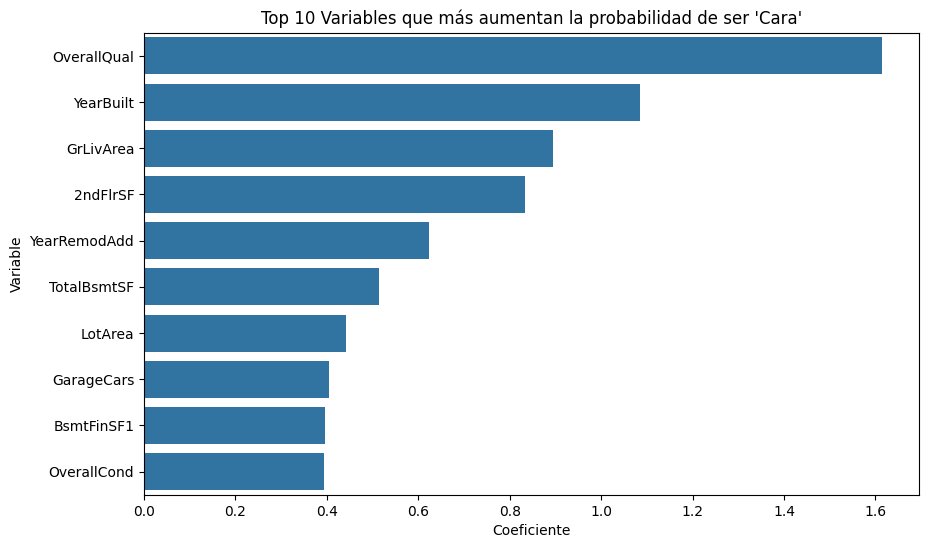

In [52]:
# Visualizar los coeficientes más relevantes
plt.figure(figsize=(10, 6))
sns.barplot(x="Coeficiente", y="Variable", data=coeficientes.head(10))
plt.title("Top 10 Variables que más aumentan la probabilidad de ser 'Cara'")
plt.show()


In [53]:
# Calcular la matriz de correlación de las variables numéricas
corr_matrix = train_df[features].corr()

# Mostrar una parte si hay muchas variables
corr_matrix.head()


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
MSSubClass,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,...,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407
LotFrontage,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,...,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450
LotArea,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,...,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261
OverallQual,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,...,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347
OverallCond,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,...,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950


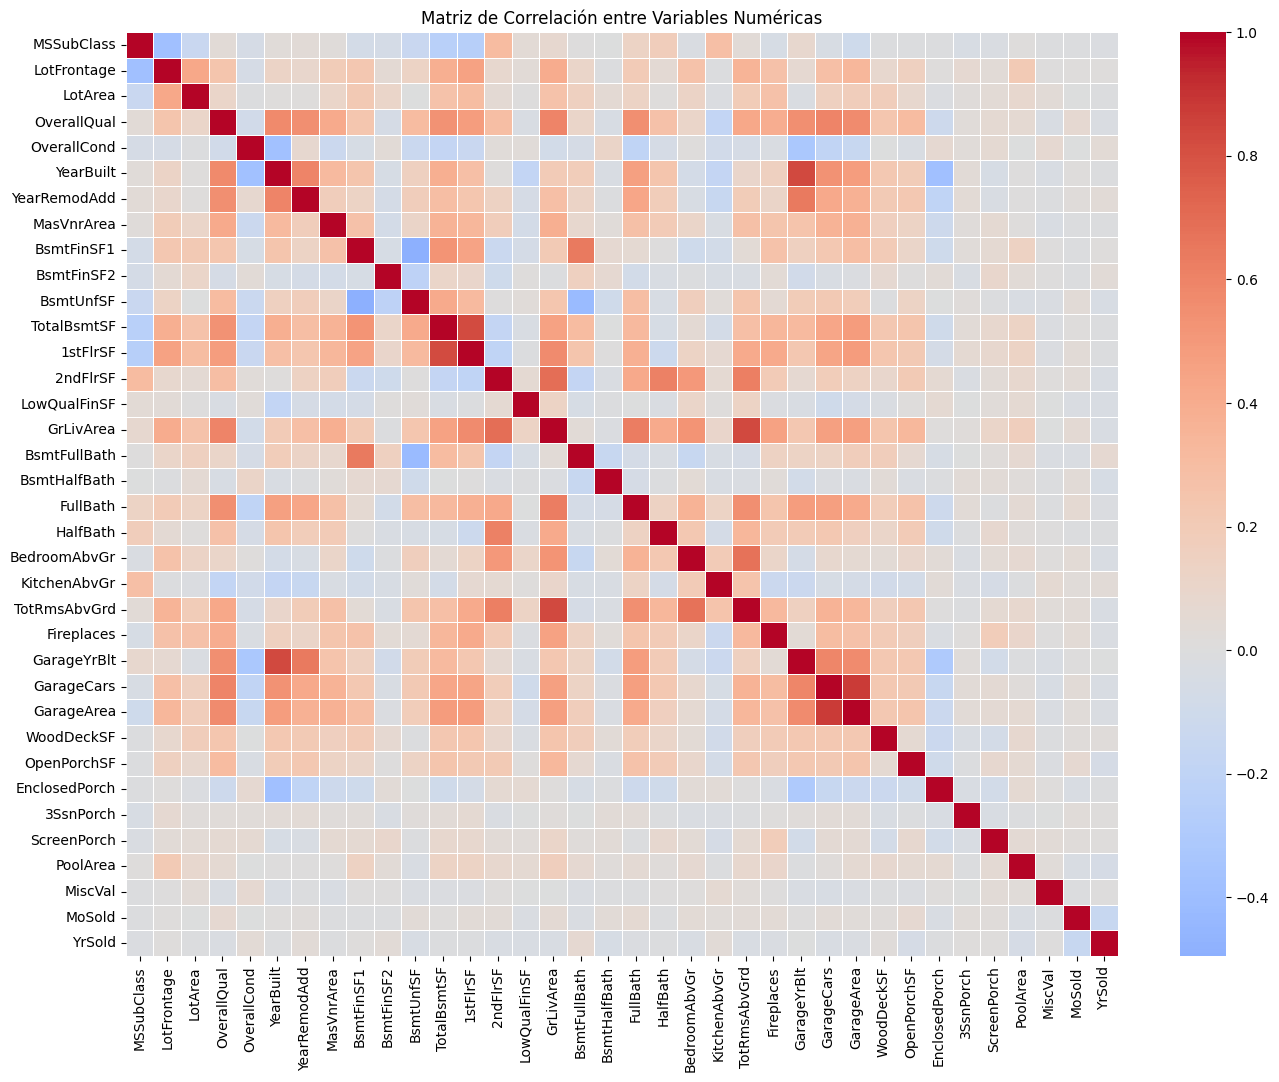

In [54]:
# Mapa de calor para visualizar la correlación entre variables
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Matriz de Correlación entre Variables Numéricas")
plt.show()


In [55]:
umbral = 0.80
correlaciones_altas = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > umbral:
            correlaciones_altas.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# Mostrar los pares con alta correlación
correlaciones_altas


[('1stFlrSF', 'TotalBsmtSF', np.float64(0.8195299750050339)),
 ('TotRmsAbvGrd', 'GrLivArea', np.float64(0.8254893743088425)),
 ('GarageYrBlt', 'YearBuilt', np.float64(0.8256674841743408)),
 ('GarageArea', 'GarageCars', np.float64(0.882475414281462))]

Solo hay una pareja con una correlación arriba de 0.85 y si cambiamos el umbral a 0.80 igual solo hay 4 parejas. Comparado a las 36 variables existentes, se puede decir que no existe multicolinealidad entre las variables, o al menos no lo suficiente para afectar el rendimiento del modelo. Como el modelo no se ve afectado realmente por esto y se quiere mantener un enfoque predictivo, se mantendrán las variables y no se hará ninguno tipo de cambio en ellas. Sin embargo, si las predicciones del modelo llegaran a fluctuar, estas serian variables interesantes para analizar y modificar.

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       264
           1       0.86      0.86      0.86       101

    accuracy                           0.92       365
   macro avg       0.90      0.90      0.90       365
weighted avg       0.92      0.92      0.92       365



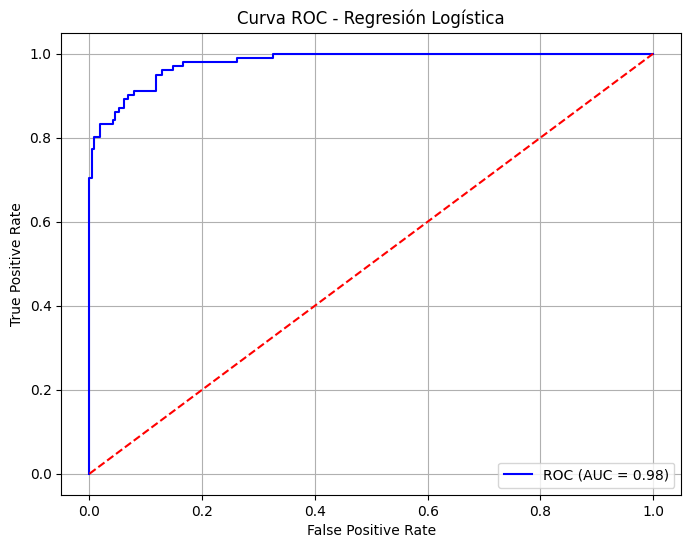

In [56]:
# Probabilidades predichas
y_probs = pipeline.predict_proba(X_test)[:, 1]

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Calcular ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

# Gráfica
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Regresión Logística")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

En esta gráfica del área bajo la curva podemos observar el desempeo del modelo. Con un 0.98 de exactitud y una gráfica visiblemente ideal, podemos decir que este modelo es muy bueno para clasificar casas como caras o no. El único punto donde llega a fluctuar es arriba del 0.8 por lo que al alejarse más del umbral de decisión (que por defecto está en 0.5) llegan a haber más falsos positivos. Sin embargo, son errores bastante bajos y no representan una debilidad crítica, así como lo vemos en la matriz de confusión.

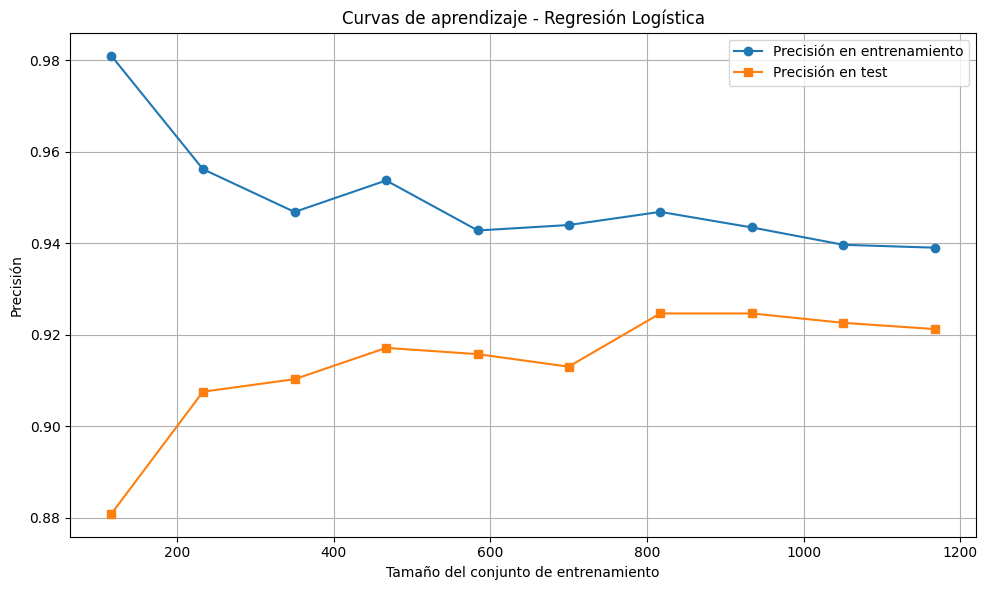

In [57]:
from sklearn.model_selection import learning_curve

# Curva de aprendizaje con pipeline
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipeline,
    X=X,
    y=y,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calcular promedios
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Precisión en entrenamiento", marker='o')
plt.plot(train_sizes, test_mean, label="Precisión en test", marker='s')
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Precisión")
plt.title("Curvas de aprendizaje - Regresión Logística")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Viendo que ambas curvas de aprendizaje parecen converger podemos decir que los el modelo si está logrando aprender de su entrenamiento y no solo memoriza la información. Esto significa que no existe un sobreajuste significativo, ya que de lo contrario la de entrenamiento estaría mucho más alta que la de test, pero en este caso es solamente una diferencia de 0.02. Además, ambas curvas se mantienen por arriba del 0.90 lo que significa que tampoco hay subajuste. Es importante resaltar que el aumento suave y sin caidas exageradas muestran que el modelo está bien regularizado. Todo esto vuelve a resaltar la robustez de este modelo de clasificación. 

### Tuneo del modelo

In [58]:
# Hiperparámetros a evaluar
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(logreg__solver=solvers, logreg__penalty=penalty, logreg__C=c_values)

# Validación cruzada repetida
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Grid Search
grid_search = GridSearchCV(estimator=pipeline, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X, y)

# Resultados
print("🔍 Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

🔍 Best: 0.924658 using {'logreg__C': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'newton-cg'}
0.924658 (0.024948) with: {'logreg__C': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'newton-cg'}
0.924429 (0.025103) with: {'logreg__C': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}
0.924658 (0.024948) with: {'logreg__C': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
0.924658 (0.024759) with: {'logreg__C': 10, 'logreg__penalty': 'l2', 'logreg__solver': 'newton-cg'}
0.924658 (0.025135) with: {'logreg__C': 10, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}
0.924658 (0.024759) with: {'logreg__C': 10, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
0.923059 (0.024802) with: {'logreg__C': 1.0, 'logreg__penalty': 'l2', 'logreg__solver': 'newton-cg'}
0.923288 (0.024403) with: {'logreg__C': 1.0, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}
0.924658 (0.023528) with: {'logreg__C': 1.0, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
0.923288

In [59]:
# Evaluación
best_model = grid_result.best_estimator_
ypred = best_model.predict(X_test)
print("\n📋 Classification Report:\n", classification_report(y_test, ypred))


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       264
           1       0.90      0.90      0.90       101

    accuracy                           0.95       365
   macro avg       0.93      0.93      0.93       365
weighted avg       0.95      0.95      0.95       365



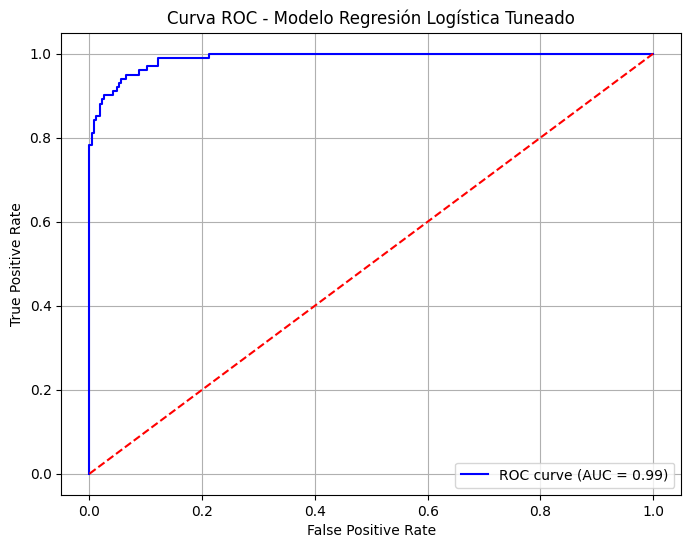

In [60]:
# ROC con probabilidades
y_probs = best_model.predict_proba(X_test)[:, 1]
logit_roc_auc = roc_auc_score(y_test, y_probs)
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Graficar
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % logit_roc_auc, color="blue")
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Modelo Regresión Logística Tuneado')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Después del tuneo, la gráfica de debajo de la curva se ve muy parecida. Sin embargo, el resultado del AUC demuestra ser de 0.99, un porciento más grande que antes. Además, la precisión (y las otras métrica también, pero como están igualadas nos enfocaremos solo en esta) aumenta, ahora siendo del 96% para no caras y 90% para caras. Por lo tanto, este modelo es muy bueno y es aún mejor para identificar casas no caras.

### Efectividad

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       264
           1       0.90      0.90      0.90       101

    accuracy                           0.95       365
   macro avg       0.93      0.93      0.93       365
weighted avg       0.95      0.95      0.95       365



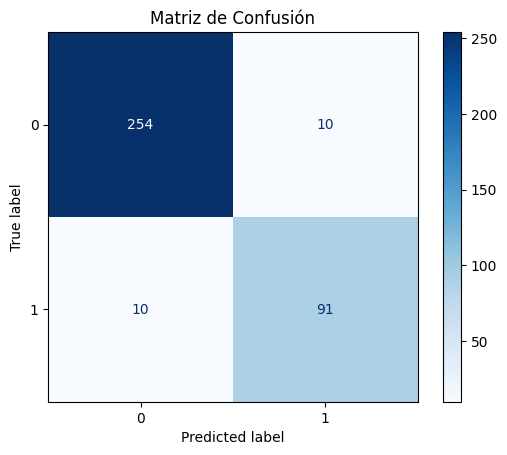

         178045 function calls (173727 primitive calls) in 0.151 seconds

   Ordered by: cumulative time
   List reduced from 1952 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.151    0.075 C:\Users\dgv31\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py:3541(run_code)
        2    0.000    0.000    0.151    0.075 {built-in method builtins.exec}
        1    0.000    0.000    0.151    0.151 C:\Users\dgv31\AppData\Local\Temp\ipykernel_33560\3995857420.py:5(evaluar_modelo)
        1    0.000    0.000    0.103    0.103 C:\Users\dgv31\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\pyplot.py:569(show)
        1    0.000    0.000    0.103    0.103 C:\Users\dgv31\AppData\Local\Packages\PythonSoftwareFoundation.Py

In [64]:
import cProfile
import pstats
from io import StringIO

def evaluar_modelo():
    y_pred = best_model.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Matriz de Confusión")
    plt.show()

# Perfilar ejecución
pr = cProfile.Profile()
pr.enable()
evaluar_modelo()
pr.disable()

# Mostrar resultados
s = StringIO()
sortby = 'cumulative'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats(15)  # Top 15 funciones más costosas
print(s.getvalue())


Enfocando su eficiencia en el tipo de errores que comete, podemos decir que este modelos puede llegar a se un poco menos fiable si el objetivo es querer conocer las casas caras, ya que es donde más error tienen. Sin embargo, como en este caso estamos enfocandonos en una predicción general, el error no es significativo. En cuanto a tiempo, crear el modelo no toma casi nada de tiempo y es más tardado la generación de las gráficas de resultados. Esto es excelente porque hace de nuestro modelo uno rápido de crear y bastante efectivo. 

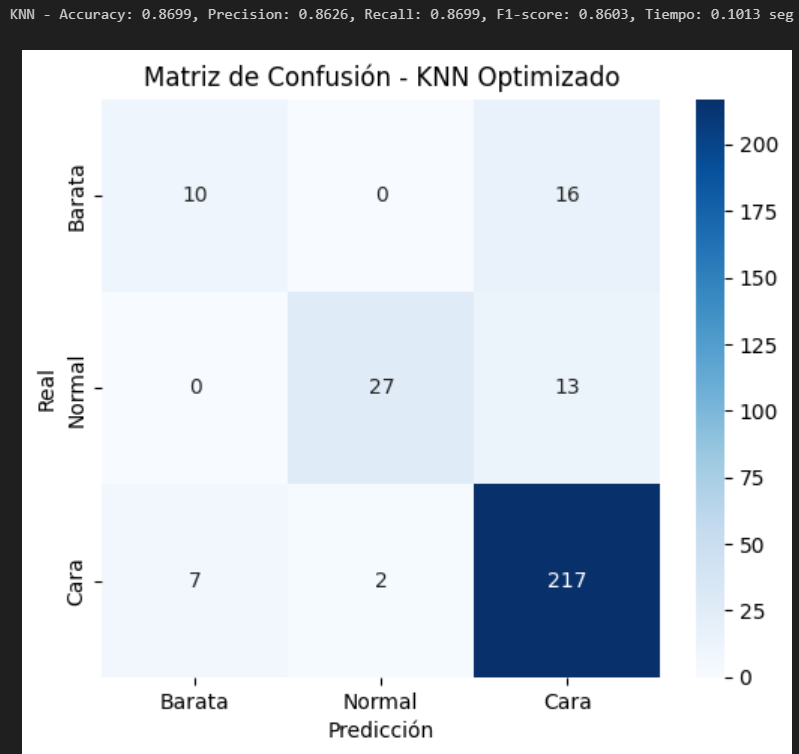
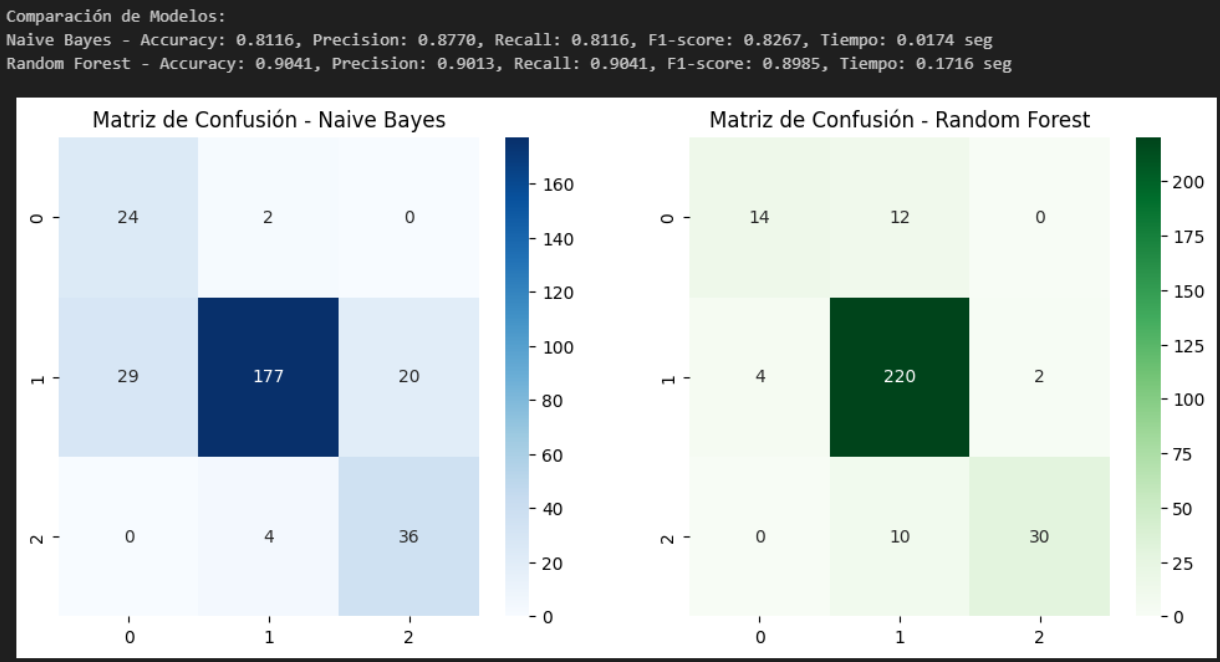

Arriba podemos ver los resultados de los modelos clasificatorios creados anteriormente. El de KNN, Naive Bayes y Random Forest. Aunque la clasificación en esta ocasión no fue la misma, si es similar, ya que queremos saber el rango de precios en el que se encuentra una casa. Viendo los métricas de precisión podemos ver que el modelo actual es bastante mejor que los anteriores. Sin embargo, al tener una clasificación menos, podríamos decir que el de regresión logística es un poco menos preciso. Por lo tanto, la calidad del modelo en este casó depende del uso. Si se busca recopilar por precios sin necesidad de diferenciar entre las de precio normal y las baratas, el de regresión logística es el claro ganador, pero si el presupuesto es muy limitado y busacamos sí o sí casas baratas, el de Random Forest da más información.